# Two-dimensional quantum dot in a harmonic oscillator potential subject to a laser field.

In this notebook we repeat the experiment from the notebook `2d-ho-quantum-dot.ipynb`, but now we use the OACCD/NOCCD groundstate calculations as our initial state for the OATDCCD calculations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from quantum_systems import TwoDimensionalHarmonicOscillator
from quantum_systems.time_evolution_operators import LaserField
from coupled_cluster.ccd import OATDCCD
from coupled_cluster.integrators import GaussIntegrator

In [2]:
class LaserPulse:

    def __init__(self, t_0=0, t_final=10, omega=8, strength=0.03):
        self.t_0 = t_0
        self.t_final = t_final
        self.omega = omega
        self.strength = strength

    def __call__(self, t):
        return self.strength * np.sin(self.omega * t)

In [3]:
n = 2
l = 20

radius = 8
num_grid_points = 401
omega = 1 / 6
mass = 1

tdho = TwoDimensionalHarmonicOscillator(n, l, radius, num_grid_points, omega=omega, mass=mass)
tdho.setup_system()
tdho.change_to_hf_basis(verbose=True, tolerance=1e-8)

HF converged to given precision in 7 iterations
Ehf: (0.769149205466088+0j)


In [4]:
polarization_vector = np.zeros(2)
polarization_vector[0] = 1

laser = LaserField(
    LaserPulse(omega=8*omega, strength=0.5),
    polarization_vector=polarization_vector
)

tdho.set_time_evolution_operator(laser)

In [5]:
integrator = GaussIntegrator(np=np, eps=1e-10)
oatdccd = OATDCCD(tdho, np=np, integrator=integrator, verbose=True)

oatdccd.compute_ground_state()
print("Ground state energy: {0}".format(oatdccd.compute_ground_state_energy()))

Iteration: 0	Residuals (t): [0.16812783736597098]
Iteration: 1	Residuals (t): [0.0572557721779723]
Iteration: 0	Residuals (l): [0.17675657029119313]
Iteration: 1	Residuals (l): [0.04858022773130223]

Iteration: 0

Residual norms: rd = 0.005315877431013836
Residual norms: ru = 0.005150341473252018
Iteration: 0	Residuals (t): [0.028517371429827]
Iteration: 1	Residuals (t): [0.012697897351282624]
Iteration: 2	Residuals (t): [0.005903012006723711]
Iteration: 3	Residuals (t): [0.0004184228812032965]
Iteration: 0	Residuals (l): [0.02690479072546809]
Iteration: 1	Residuals (l): [0.01100448064378905]
Iteration: 2	Residuals (l): [0.00576906174144939]
Iteration: 3	Residuals (l): [0.0003638740461711256]

Iteration: 1

Residual norms: rd = 0.0006033758737821062
Residual norms: ru = 0.0006925526437407529
Iteration: 0	Residuals (t): [0.0006881955439670257]
Iteration: 1	Residuals (t): [0.00019673072091031565]
Iteration: 2	Residuals (t): [4.671971535795751e-05]
Iteration: 0	Residuals (l): [0.000521804

In [6]:
# TODO: The ground state particle density is _not_ coreect for the
# OACCD ground state. Make sure that the transformed basis is used.
rho = oatdccd.compute_ground_state_particle_density()

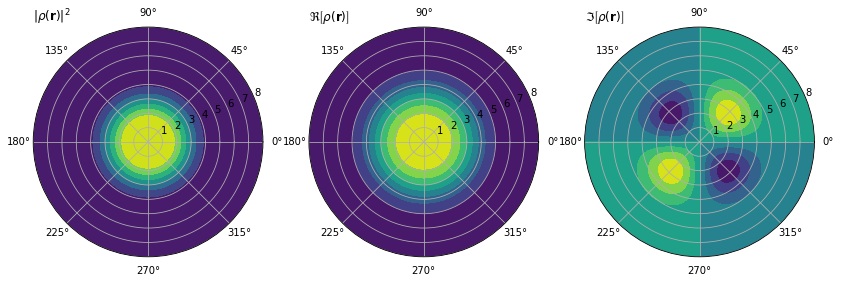

In [7]:
fig = plt.figure(figsize=(14, 10))

ax = fig.add_subplot(1, 3, 1, polar=True)
ax.set_title(r"$|\rho(\mathbf{r})|^2$", loc="left")
plt.contourf(tdho.T, tdho.R, np.abs(rho * rho.conj()))

ax = fig.add_subplot(1, 3, 2, polar=True)
ax.set_title(r"$\Re\left[\rho(\mathbf{r})\right]$", loc="left")
plt.contourf(tdho.T, tdho.R, rho.real)

ax = fig.add_subplot(1, 3, 3, polar=True)
ax.set_title(r"$\Im\left[\rho(\mathbf{r})\right]$", loc="left")
plt.contourf(tdho.T, tdho.R, rho.imag)
plt.show()

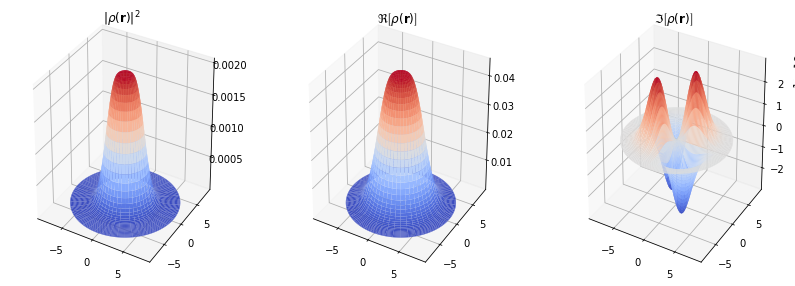

In [8]:
X, Y = tdho.R * np.cos(tdho.T), tdho.R * np.sin(tdho.T)

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 3, 1, projection="3d")

ax.plot_surface(X, Y, np.abs(rho * rho.conj()), cmap=cm.coolwarm)
plt.title(r"$|\rho(\mathbf{r})|^2$")

#fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 3, 2, projection="3d")

ax.plot_surface(X, Y, rho.real, cmap=cm.coolwarm)
plt.title(r"$\Re\left[\rho(\mathbf{r})\right]$")

#fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 3, 3, projection="3d")

ax.plot_surface(X, Y, rho.imag, cmap=cm.coolwarm)
plt.title(r"$\Im\left[\rho(\mathbf{r})\right]$")

plt.show()

In [9]:
oatdccd.set_initial_conditions()

In [10]:
num_timesteps = 801
t_end = 8
time_points = np.linspace(0, t_end, num_timesteps)

In [11]:
psi_overlap = np.zeros(num_timesteps, dtype=np.complex128)
td_energies = np.zeros(num_timesteps, dtype=np.complex128)
dip_z = np.zeros_like(td_energies)

psi_overlap[0] = oatdccd.compute_time_dependent_overlap()
td_energies[0] = oatdccd.compute_energy()

t, l, C, C_tilde = oatdccd.amplitudes
rho_qp = oatdccd.compute_one_body_density_matrix()
rho_qp = 0.5 * (rho_qp.conj().T + rho_qp)

z = C_tilde @ tdho.dipole_moment[0] @ C
dip_z[0] = np.trace(rho_qp @ z)

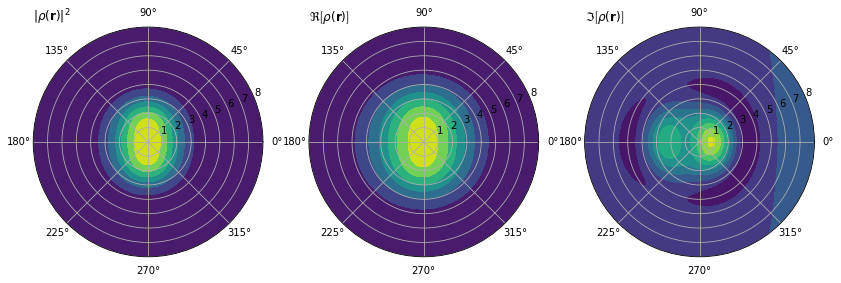

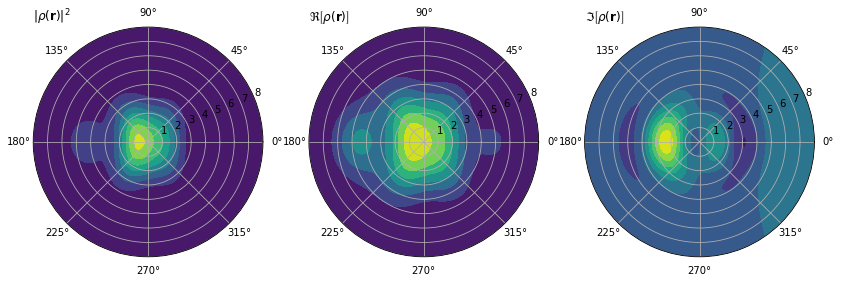

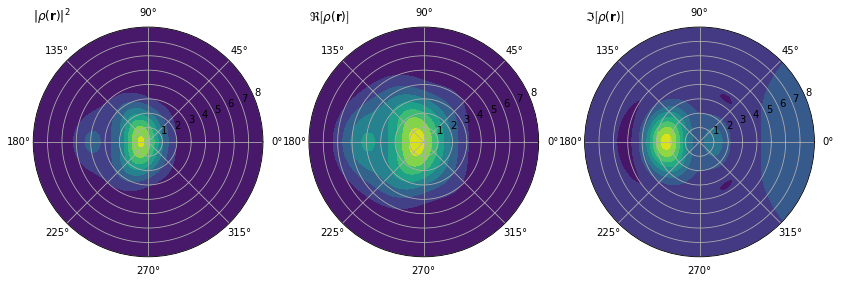

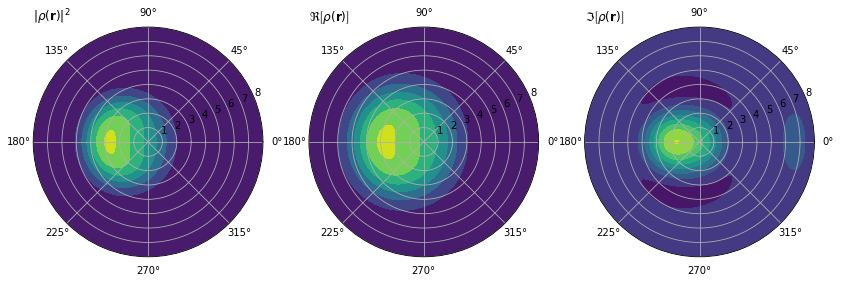

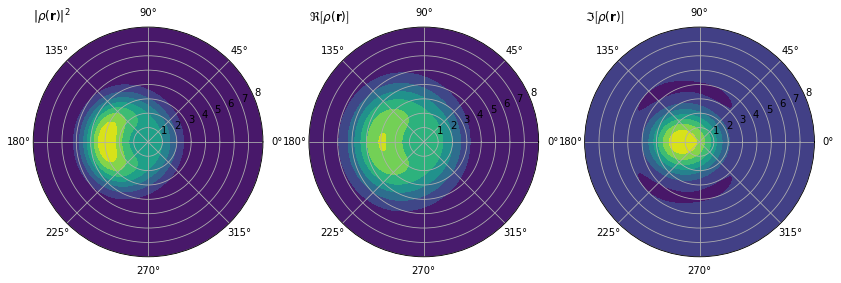

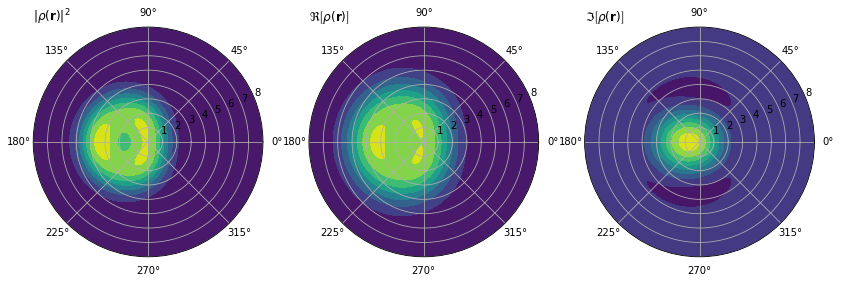

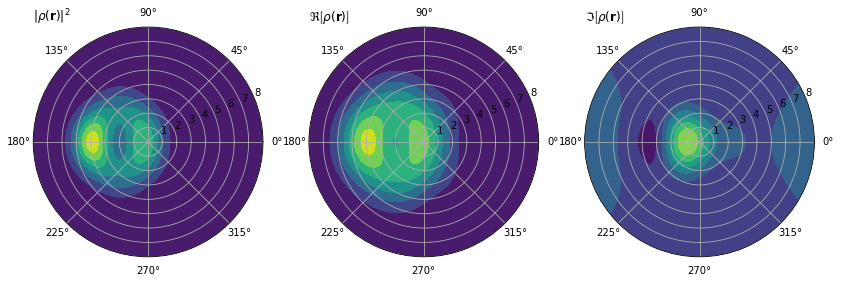

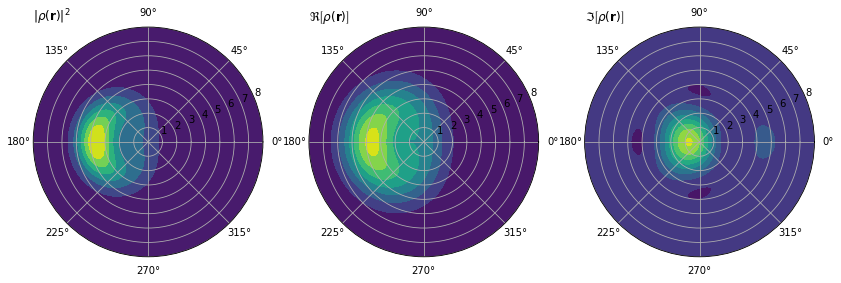

In [12]:
step_final = num_timesteps - 1
plot_3d = False
plot_step_freq = 100

for i, amp in enumerate(oatdccd.solve(time_points)):
    t, l, C, C_tilde = amp
    step = i + 1
    print(100 * " ", end="\r")
    print(f"step = {step} / {step_final}", end="\r")
    psi_overlap[i + 1] = oatdccd.compute_time_dependent_overlap()
    td_energies[i + 1] = oatdccd.compute_energy()

    rho_qp = oatdccd.compute_one_body_density_matrix()
    rho_qp = 0.5 * (rho_qp.conj().T + rho_qp)

    z = C_tilde @ tdho.dipole_moment[0] @ C
    dip_z[i + 1] = np.trace(rho_qp @ z)
    

    if not plot_3d and step % plot_step_freq == 0:
        rho = oatdccd.compute_particle_density()

        fig = plt.figure(figsize=(14, 10))

        ax = fig.add_subplot(1, 3, 1, polar=True)
        ax.set_title(r"$|\rho(\mathbf{r})|^2$", loc="left")
        plt.contourf(tdho.T, tdho.R, np.abs(rho * rho.conj()))

        ax = fig.add_subplot(1, 3, 2, polar=True)
        ax.set_title(r"$\Re\left[\rho(\mathbf{r})\right]$", loc="left")
        plt.contourf(tdho.T, tdho.R, rho.real)

        ax = fig.add_subplot(1, 3, 3, polar=True)
        ax.set_title(r"$\Im\left[\rho(\mathbf{r})\right]$", loc="left")
        plt.contourf(tdho.T, tdho.R, rho.imag)

        plt.show()

    if plot_3d and step % plot_step_freq == 0:
        rho = oatdccd.compute_particle_density()

        fig = plt.figure(figsize=(14, 5))
        ax = fig.add_subplot(1, 3, 1, projection="3d")

        ax.plot_surface(X, Y, np.abs(rho * rho.conj()), cmap=cm.coolwarm)
        plt.title(r"$|\rho(\mathbf{r})|^2$")

        #fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(1, 3, 2, projection="3d")

        ax.plot_surface(X, Y, rho.real, cmap=cm.coolwarm)
        plt.title(r"$\Re\left[\rho(\mathbf{r})\right]$")

        #fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(1, 3, 3, projection="3d")

        ax.plot_surface(X, Y, rho.imag, cmap=cm.coolwarm)
        plt.title(r"$\Im\left[\rho(\mathbf{r})\right]$")

        plt.show()

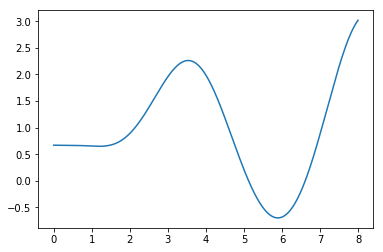

In [13]:
plt.plot(time_points, td_energies.real)
plt.show()

In [14]:
rho = oatdccd.compute_particle_density()

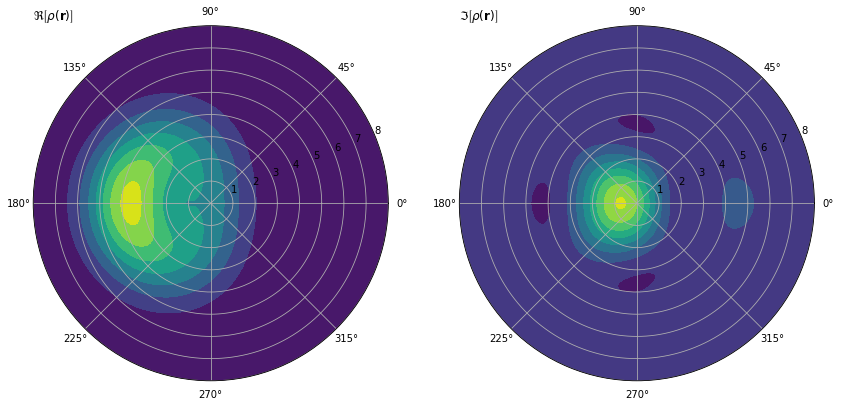

In [15]:
fig = plt.figure(figsize=(14, 10))

ax = fig.add_subplot(1, 2, 1, polar=True)
ax.set_title(r"$\Re\left[\rho(\mathbf{r})\right]$", loc="left")
plt.contourf(tdho.T, tdho.R, rho.real)

ax = fig.add_subplot(1, 2, 2, polar=True)
ax.set_title(r"$\Im\left[\rho(\mathbf{r})\right]$", loc="left")
plt.contourf(tdho.T, tdho.R, rho.imag)
plt.show()

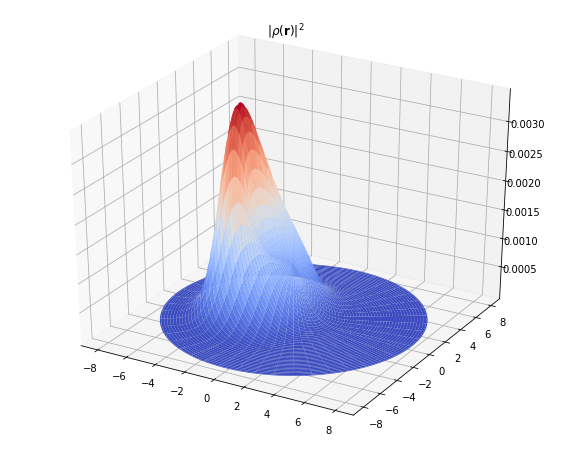

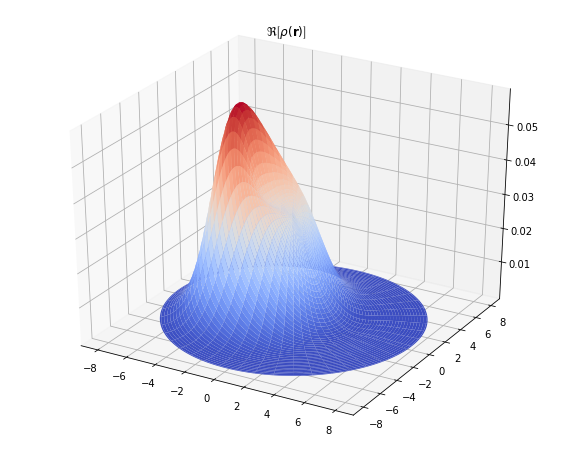

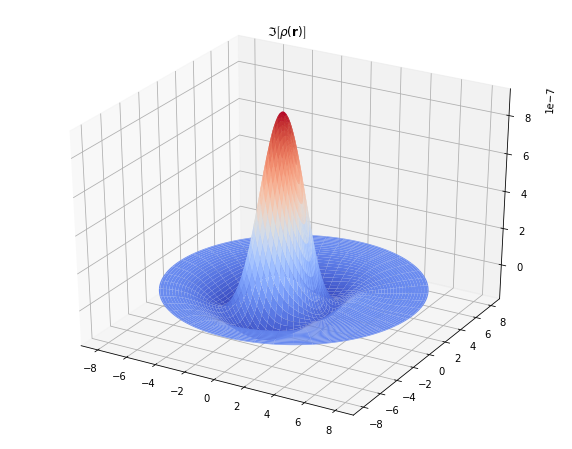

In [16]:
X, Y = tdho.R * np.cos(tdho.T), tdho.R * np.sin(tdho.T)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(X, Y, np.abs(rho * rho.conj()), cmap=cm.coolwarm)
plt.title(r"$|\rho(\mathbf{r})|^2$")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(X, Y, rho.real, cmap=cm.coolwarm)
plt.title(r"$\Re\left[\rho(\mathbf{r})\right]$")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(X, Y, rho.imag, cmap=cm.coolwarm)
plt.title(r"$\Im\left[\rho(\mathbf{r})\right]$")

plt.show()

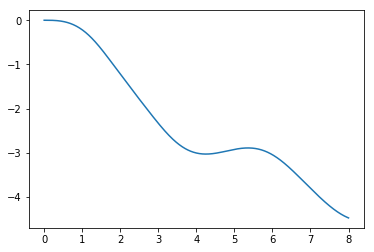

In [20]:
plt.plot(time_points, dip_z.real)
plt.show()